In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv('../data/01_data_mars_triangulation.csv')

In [2]:
df.head(100)

,PairIndex,Day,Month,Year,DegreeEarthLocationHelioCentric,MinuteEarthLocationHelioCentric,DegreeMarsLocationGeoCentric,MinuteMarsLocationGeoCentric
0,1,17,2,1585,159,23,135,12
1,1,5,1,1587,115,21,182,8
2,2,19,9,1591,5,47,284,18
3,2,6,8,1593,323,26,346,56
4,3,7,12,1593,85,53,3,4
5,3,25,10,1595,41,42,49,42
6,4,28,3,1587,196,50,168,12
7,4,12,2,1589,153,42,218,48
8,5,10,3,1585,179,41,131,48
9,5,26,1,1587,136,6,184,42


In [3]:
def get_as_radian(degree,minute,second=0,zodiac_index=0):
    base_angle=zodiac_index*30
    deg_angle=base_angle+degree+(minute/60.0)+(second/3600.0)
    return np.radians(deg_angle)

In [4]:
A=[] #heliocentric angle of earth
B=[] #paired heliocentric angle of earth
C=[] #geocentric angle of mars
D=[] #paired geocentric angle of mars

for i in range(1,6):
    rows=df[df['PairIndex']==i]
    A.append(get_as_radian(rows.iloc[0]['DegreeEarthLocationHelioCentric'],rows.iloc[0]['MinuteEarthLocationHelioCentric']))
    B.append(get_as_radian(rows.iloc[1]['DegreeEarthLocationHelioCentric'],rows.iloc[1]['MinuteEarthLocationHelioCentric']))
    C.append(get_as_radian(rows.iloc[0]['DegreeMarsLocationGeoCentric'],rows.iloc[0]['MinuteMarsLocationGeoCentric']))
    D.append(get_as_radian(rows.iloc[1]['DegreeMarsLocationGeoCentric'],rows.iloc[1]['MinuteMarsLocationGeoCentric']))
A=np.array(A)
B=np.array(B)
C=np.array(C)
D=np.array(D)

In [5]:
def get_coordinates(A,B,C,D):
    x=(np.tan(D)*np.cos(B)-np.tan(C)*np.cos(A)-np.sin(B)+np.sin(A))/(np.tan(D)-np.tan(C))
    y=np.sin(A)+np.tan(C)*(x-np.cos(A))
    return (x,y)

In [6]:
x,y=get_coordinates(A,B,C,D)

In [7]:
x,y

(array([-1.45297367,  1.19567278,  1.07388531, -1.63230459, -1.55376733]),
 array([ 0.86553353, -0.68685663,  1.05110693, -0.1485418 ,  0.62489899]))

In [14]:
def circle_fit_objective(r,x,y):
    return np.sum((np.sqrt(x**2+y**2)-r)**2)

In [15]:
from scipy.optimize import minimize
r=np.random.rand(1)
print (r)
res=minimize(circle_fit_objective,r,args=(x,y))
print (res)
Radius=res.x

[0.48831025]
      fun: 0.07120993396639348
 hess_inv: array([[0.1]])
      jac: array([4.65661287e-09])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([1.57732091])


In [19]:
df_opp=pd.read_csv('../data/01_data_mars_opposition.csv')

In [20]:
df_opp.head(100)

,Day,Month,Year,ZodiacIndex,Degree,Minute,Second,LatDegree,LatMinute,ZodiacIndexAverageSun,DegreeMean,MinuteMean,SecondMean
0,18,11,1580,2,6,28,35,1,40,1,25,49,31
1,28,12,1582,3,16,55,30,4,6,3,9,24,55
2,30,1,1585,4,21,36,10,4,32,4,20,8,9
3,6,3,1587,5,25,43,0,3,41,6,0,47,40
4,14,4,1589,7,4,23,0,1,12,7,14,18,26
5,8,6,1591,8,26,43,0,-4,0,9,5,43,55
6,25,8,1593,11,12,16,0,-6,-2,11,9,49,31
7,31,10,1595,1,17,31,40,0,8,1,9,55,4
8,13,12,1597,3,2,28,0,3,33,2,23,11,56
9,18,1,1600,4,8,38,0,4,30,4,4,35,50


In [21]:
mars_lat_geo=get_as_radian(df_opp['LatDegree'],df_opp['LatMinute'])

In [228]:
#returns mars heliocentric lats from geocentric lats and dis of mars from sun
def get_mars_helio_lat(mars_lat_geo,radius):
    y= (radius-1)*np.tan(mars_lat_geo)
    return np.arctan(y/radius)

In [229]:
mars_lat_helio=get_mars_helio_lat(mars_lat_geo,Radius)
mars_long_helio=get_as_radian(df_opp['Degree'],df_opp['Minute'],df_opp['Second'],df_opp['ZodiacIndex'])

In [230]:
def get_mars_3d(alpha,beta):
    X=-np.cos(alpha)*np.sin(beta)
    Y=np.cos(alpha)*np.cos(beta)
    Z=np.sin(alpha)
    return (X,Y,Z)

def mars_plane_objective(normal_dirn,alpha,beta):
    X=-np.cos(alpha)*np.sin(beta)
    Y=np.cos(alpha)*np.cos(beta)
    Z=np.sin(alpha)
    dis=(X*normal_dirn[0]+Y*normal_dirn[1]+Z*normal_dirn[2])/np.sqrt(np.sum(normal_dirn**2))
    return np.sum(dis**2)

In [231]:
dirn=np.random.uniform(low=-1, high=1, size=(3,))
print (dirn)
res=minimize(mars_plane_objective,dirn,args=(mars_lat_helio,mars_long_helio))
print (res.x/np.sqrt(np.sum(res.x**2)))
print (res)

[ 0.82550194 -0.77607282  0.24797288]
[0.02208052 0.02361303 0.9994773 ]
      fun: 0.00014653354180996307
 hess_inv: array([[ 2.08282907, -0.19941544, -0.51455369],
       [-0.19941544,  2.21441668,  0.46875352],
       [-0.51455369,  0.46875352,  2.50272173]])
      jac: array([-1.69216764e-06, -8.84454494e-07,  5.84368536e-08])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([0.11529289, 0.12329489, 5.21874679])


In [232]:
mars_plane=(res.x/np.sqrt(np.sum(res.x**2)))
print(mars_plane)

[0.02208052 0.02361303 0.9994773 ]


In [233]:
sin_inclination=np.sqrt(np.sum(np.cross(mars_plane,np.array([0,0,1]))**2))/(np.sqrt(np.sum(mars_plane**2))) #001 is normal to xy plane.(horizontal plane)

In [234]:
inclination=np.arcsin(sin_inclination)

In [235]:
np.degrees(inclination)

1.85260289331129

In [236]:
#returns mars' 3d coordinates from equation of plane and x,y coordinates
def get_mars_plane_projection(normal_dirn,x,y):
    z=(normal_dirn[0]*x+normal_dirn[1]*y)/normal_dirn[2]
    return (x,y,z)

In [237]:
X,Y,Z=get_mars_plane_projection(mars_plane,x,y)

In [238]:
#given n, n>1 3d points lying on a plane and normal to the plane this method returns the points in 2d coordinates u-v on plane.
def coordinate_transform(X,Y,Z,normal_dirn):
    u=np.array([X[0]-X[1],Y[0]-Y[1],Z[0]-Z[1]]) #vector on plane
    v=np.cross(normal_dirn,u)
    u=u/np.sqrt(np.sum(u**2)) #unit vector
    v=v/np.sqrt(np.sum(v**2)) 
    #let U,V be the respective coordinates in this new system then,
    U=np.dot(u,(X,Y,Z))
    V=np.dot(v,(X,Y,Z))
    return (U,V)

In [239]:
U,V=coordinate_transform(X,Y,Z,mars_plane)
U,V

(array([ 1.69123382, -1.37889976, -0.39531664,  1.33338403,  1.65657111]),
 array([-0.01200473, -0.01200473, -1.44767902,  0.9521125 ,  0.24618014]))

In [240]:
r_mc=np.random.rand(1)
print (r_mc)
res_mc=minimize(circle_fit_objective,r_mc,args=(U,V))
print (res_mc)
Radius=res_mc.x

[0.29110394]
      fun: 0.07143672941988749
 hess_inv: array([[0.1]])
      jac: array([-4.09781933e-08])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([1.57681966])


In [241]:
def ellipse_fit_objective(params,u,v):
    a=params[0]
    eccentricity=params[1]
    b=np.sqrt(a*a*(1-eccentricity**2))
    delta=params[2]
    X=u*np.cos(delta)+v*np.sin(delta)
    Y=v*np.cos(delta)-u*np.sin(delta)+np.sqrt(a**2-b**2)
    f=(X/a)**2+(Y/b)**2-1
    return np.sum(f**2)

In [242]:
from scipy.optimize import Bounds
r_me=np.random.rand(3)
print (r_me)
bounds=Bounds([0,0,0],[np.inf,1,2*np.pi])
res_me=minimize(ellipse_fit_objective,r_me,args=(U,V),bounds=bounds)
print (res_me)

[0.20411267 0.12079466 0.53419153]
      fun: 0.0002577485756935398
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([7.75589445e-07, 8.20036313e-08, 7.66801986e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 96
      nit: 19
   status: 0
  success: True
        x: array([1.53661524, 0.10014414, 1.46067496])


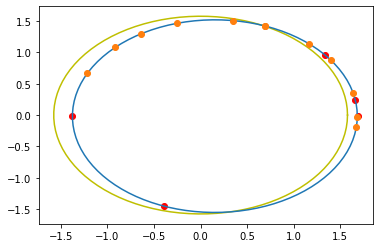

In [252]:
def get_uv(t,delta,A,ecc):
    B=A*np.sqrt(1-ecc**2)
    u_=A*np.cos(t)
    v_=B*np.sin(t)-A*ecc
    x=u_*np.cos(delta)-v_*np.sin(delta)
    y=u_*np.sin(delta)+v_*np.cos(delta)
    return (x,y)

import matplotlib.pyplot as plt

plt.plot(U,V,'ro')

t=np.linspace(0,2*np.pi,100)

circ_x=Radius*np.cos(t)
circ_y=Radius*np.sin(t)
plt.plot(circ_x,circ_y,'y')

A,ecc,delta=res_me.x
ellip_x,ellip_y=get_uv(t,delta,A,ecc)
plt.plot(ellip_x,ellip_y)
M_x,M_y,M_z=get_mars_3d(mars_lat_helio,mars_long_helio)
M_x,M_y,M_z=get_mars_plane_projection(mars_plane,M_x,M_y)
M_u,M_v=coordinate_transform(M_x,M_y,M_z,mars_plane)

T=np.arctan(M_v/M_u)
m12_x,m12_y=get_uv(T,delta,A,ecc)
plt.plot(m12_x,m12_y,'o')
plt.show()

In [333]:
def cost(x,y,z,normal_dirn): #squared sum of distances of (x,y,z) from plane with normal_dirn as normal
    dis=(x*normal_dirn[0]+y*normal_dirn[1]+z*normal_dirn[2])/np.sqrt(np.sum(normal_dirn**2))
    return np.sum(dis**2)

def grad_sig_f_sq(x,y,z,normal_dirn):
    S=np.sum(normal_dirn**2)
    A,B,C=normal_dirn
    V=(A*x+B*y+C*z)
    df_da=(1/S)*(2*np.sum(V*x))-(2*A/(S*S))*(np.sum(V**2))
    df_db=(1/S)*(2*np.sum(V*y))-(2*B/(S*S))*(np.sum(V**2))
    df_dc=(1/S)*(2*np.sum(V*z))-(2*C/(S*S))*(np.sum(V**2))
    return np.array([df_da,df_db,df_dc])

In [360]:
def bisection(x,y,z,theta,grad,left,right,tolerance=1e-5):
    while(right-left>tolerance):
        mid=(left+right)/2
        mid_l=mid-tolerance/4
        mid_r=mid+tolerance/4
        cost_l=cost(x,y,z,theta-grad*mid_l)
        cost_r=cost(x,y,z,theta-grad*mid_r)
        if cost_l>cost_r:
            left=mid_l
        else:
            right=mid_r
    return (left+right)/2

def grad_desc(x,y,z):
    theta=np.random.uniform(low=-1, high=1, size=(3,))
    eps=1e-5
    gf=grad_sig_f_sq(x,y,z,theta)
    mod_gf=np.sum(gf**2)
    i=0
    while(mod_gf>eps):
        i+=1
        mod_gf=np.sum(gf**2)
        gf=grad_sig_f_sq(x,y,z,theta)
        alpha_min=bisection(x,y,z,theta,gf,0,1)
        theta=theta-alpha_min*gf
        if i%1==0:
            print("Current Iteration:",i,"gradient mod:",mod_gf,"cost:",cost(x,y,z,theta),"current inclination",get_inclination(theta))
    return theta,cost(x,y,z,theta)

In [361]:
m_x,m_y,m_z=get_mars_3d(mars_lat_helio,mars_long_helio)
res=grad_desc(m_x,m_y,m_z)

Current Iteration: 1 gradient mod: 6.08006796129063 cost: 0.32656992021885783 current inclination 13.150551874303675
Current Iteration: 2 gradient mod: 6.08006796129063 cost: 0.0007184953088075032 current inclination 2.368037087322535
Current Iteration: 3 gradient mod: 1.0702948275485182 cost: 0.00014748003111077744 current inclination 1.8449359772818335
Current Iteration: 4 gradient mod: 0.0019610072114885375 cost: 0.00014653510373605313 current inclination 1.8534805754469839
Current Iteration: 5 gradient mod: 3.1037289834345053e-06 cost: 0.00014653354033651792 current inclination 1.8526332983009075


In [362]:
test=res[0]

In [363]:
def get_inclination(test):
    sin_inclination=np.sqrt(np.sum(np.cross(test,np.array([0,0,1]))**2))/(np.sqrt(np.sum(test**2))) #001 is normal to xy plane.(horizontal plane)
    inclination=np.arcsin(sin_inclination)
    return np.degrees(inclination)

In [364]:
print(get_inclination(test))

1.8526332983009075


In [365]:
t=np.array([0.02208052, 0.02361303 ,0.9994773 ])
print(cost(m_x,m_y,m_z,t))
print(np.sum(grad_sig_f_sq(m_x,m_y,m_z,t)**2))

0.00014653354179815326
9.969395548871952e-11
